In [ ]:
import theano
import theano.tensor as T
import lasagne
import h5py
import numpy as np
import sys

sys.path.append("..")
from networks import  residual_unet, debug_net

In [ ]:
DATASET_TRAIN = '/home/sebastianschlecht/depth_data/nyu_v1_shuffled_cc'
DATASET = '/home/sebastianschlecht/depth_data/nyu_depth_v2_resized'
 
model = '../data/resunet_imrot_epoch_100.npz'
f = h5py.File(DATASET_TRAIN + ".hdf5")
length = f["images"].shape[0]
images = np.array(f["images"][0:100]).astype(np.float32)
images_orig = images.copy()
depths = np.array(f["depths"][0:100]).astype(np.float32)
m = np.load(DATASET_TRAIN + ".npy").astype(np.float32)
for i in range(images.shape[0]):
    images[i] = (images[i] - m) / 70.933385161726605
    

input_var = T.tensor4('inputs')
network = residual_unet(input_var=input_var)
# Downsample factor
ds = 2
prediction = lasagne.layers.get_output(network, deterministic=True)

if model is not None:
    print "Loading model weights %s" % model
    with np.load(model) as f:
        param_values = [f['arr_%d' % i] for i in range(len(f.files))]
    lasagne.layers.set_all_param_values(network, param_values)
fn = theano.function([input_var], prediction)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
mm = []
ds = 2
bs = 1
for idx in range(90,100):
    sample = images[idx:idx+bs,:,9:9+240, 12:12+320].astype(np.float32)
    r = fn(sample.reshape((-1,3,240,320)))
    r = r[0].squeeze()
    d = depths[idx:idx+bs, 9:9+240, 12:12+320]
    d = d[:,::ds,::ds]
    d = d[0] #,15:-15,20:-20]
    # r = r[15:-15,20:-20]
    if idx % 1 == 0:
        plt.imshow(images_orig[idx].astype(np.uint8).transpose((1,2,0)))
        plt.show()
        plt.imshow(r)
        plt.show()
        plt.imshow(d)
        plt.show()
        plt.show()
    m = (((d[d>0]) - (r[d>0])) ** 2).flatten()
    mm.append(m)
print np.sqrt(np.concatenate(mm).mean())


In [138]:
import numpy
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """ 
     
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
        

    if window_len<3:
        return x
    
    
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
    

    s=numpy.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=numpy.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')
    
    y=numpy.convolve(w/w.sum(),s,mode='valid')
    return y    

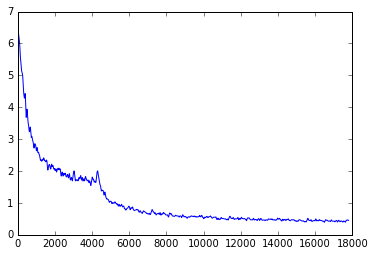

7


In [143]:
import numpy as np
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
DATASET_TRAIN = '/home/sebastianschlecht/depth_data/nyu_v1_shuffled_cc'
DATASET = '/home/sebastianschlecht/depth_data/nyu_depth_v2_resized'
 
f = h5py.File(DATASET_TRAIN + ".hdf5")
ttype = "train"

d = np.load("../data/resunet_nol2_epoch_40_loss_%s.npy" % ttype)

plt.plot(smooth(d, window_len=100))
plt.show()

llen = f["images"].shape[0]

print llen % 16





In [1]:
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.append("..")
from main import start_prefetching_thread, iterate_minibatches_synchronized

start_prefetching_thread((16, True))


<Thread(Thread-4, started daemon 140579010721536)>

67015


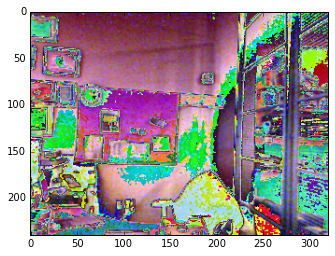

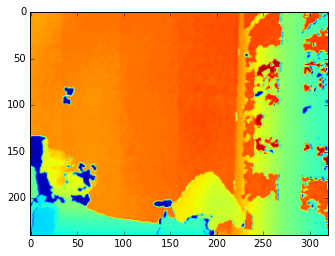

-0.236683
4.187


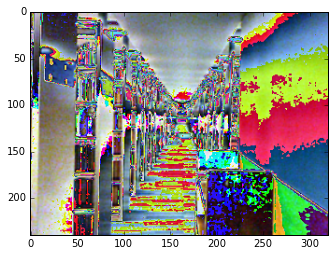

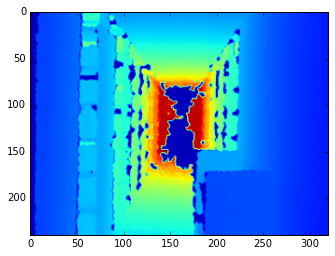

-0.507597
9.03364


In [21]:
import time
import math
import h5py
DATASET_TRAIN = '/home/sebastianschlecht/depth_data/nyu_v1_shuffled_cc'
DATASET = '/home/sebastianschlecht/depth_data/nyu_depth_v2_resized'
 
f = h5py.File(DATASET_TRAIN + ".hdf5")

llen = f["images"].shape[0]
print llen
idx = 4
for e in range(1):
    for batch in iterate_minibatches_synchronized(32,16):
        
        inp,t = batch
        plt.imshow(inp[idx].transpose((1,2,0)))
        plt.show()
        plt.imshow(t[idx])
        plt.show()
        
        print t[idx].min()
        print t[idx].max()
        
        
        

In [25]:
offset = -1000
ii = np.array(f["images"][offset:])
dd = np.array(f["depths"][offset:])


In [38]:
from scipy.ndimage.interpolation import zoom,rotate


def zoom_rot(ii,dd):
        """ Rotate and zoom an image around a given angle"""
        a = np.random.randint(-5,5)
        ddr = rotate(dd,a, order=1)
        iir = rotate(ii.transpose((1,2,0)),a, order=1)
        
        f = np.random.randint(121,130) / 100.
        
        
        h = int(dd.shape[0] / f)
        w = int(dd.shape[1] / f)
        
        s_fh = float(dd.shape[0]) / float(h)
        s_fw = float(dd.shape[1]) / float(w)

        s_f = (s_fh + s_fw) / 2.
        

        cy = np.random.randint(20,dd.shape[0] - h - 20)
        cx = np.random.randint(20,dd.shape[1] - w - 20)

        ddc = ddr[cy:cy+h, cx:cx+w]
        iic = iir[cy:cy+h,cx:cx+w,:]

        dd_s = zoom(ddc,(s_fh, s_fw),order=0)
        dd_s /= s_f
        ii_s = iic.transpose((2,0,1))
        
        ii_s = zoom(ii_s,(1,s_fh,s_fw),order=0)
        
        return ii_s, dd_s

for index in range(ii.shape[0]):
    plot = False
    ie = ii[index]
    de = dd[index]
    
    ie, de = zoom_rot(ie, de)
    
    if de.max() > 12.:
        print "max: ", de.max()
        plot = True
    
    if plot:
        plt.imshow(ii[index].transpose((1,2,0)))
        plt.show()
        plt.imshow(dd[index])
        plt.show()

KeyboardInterrupt: 

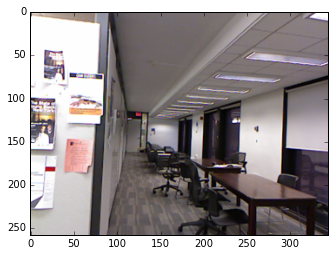

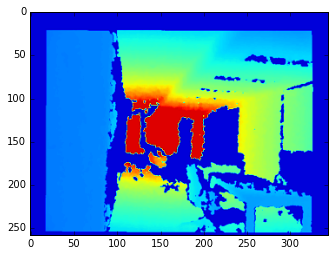

a 123.638652275
b 2.77161
c 127.210624362
d 2.69217


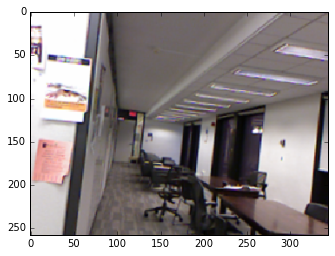

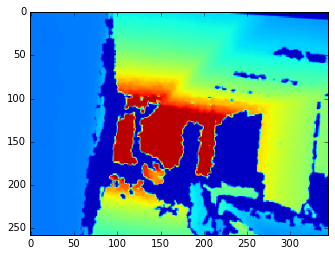

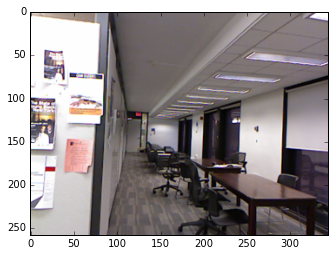

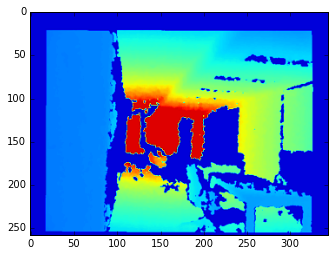

In [106]:
idx += 1

plt.imshow(ii[idx].transpose((1,2,0)))
plt.show()
plt.imshow(dd[idx])
plt.show()

a,b = zoom_rot(ii[idx].copy(), dd[idx].copy())
c,d = ii[idx].copy(), dd[idx].copy()

print "a", a.mean()
print "b", b.mean()
print "c", c.mean()
print "d",d.mean()



plt.imshow(a.transpose((1,2,0)))
plt.show()
plt.imshow(b)
plt.show()
plt.imshow(c.transpose((1,2,0)))
plt.show()
plt.imshow(d)
plt.show()
